In [5]:
import networkx as nx 
import numpy as np 
import torch

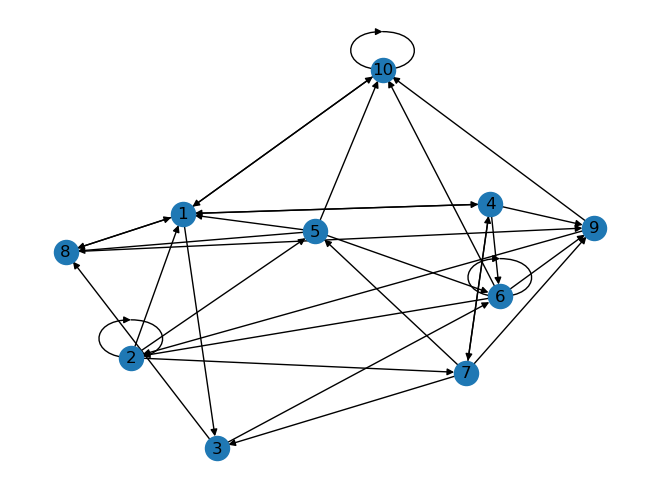

In [15]:
G1 = nx.read_edgelist('lab1/lab1_small_edgelist.txt', create_using = nx.DiGraph(), 
                      nodetype = None, data = [('weight', int)])
nx.draw(G1, with_labels = True)

In [28]:
def build_graph(adj_matrix):
    G = nx.DiGraph()
    n = len(adj_matrix)

    for i in range(n):
        G.add_edge(i, i)
        for j in range(len(adj_matrix[i])):
            if adj_matrix[i][j] == 1: G.add_edge(i, j)
    
    return G            

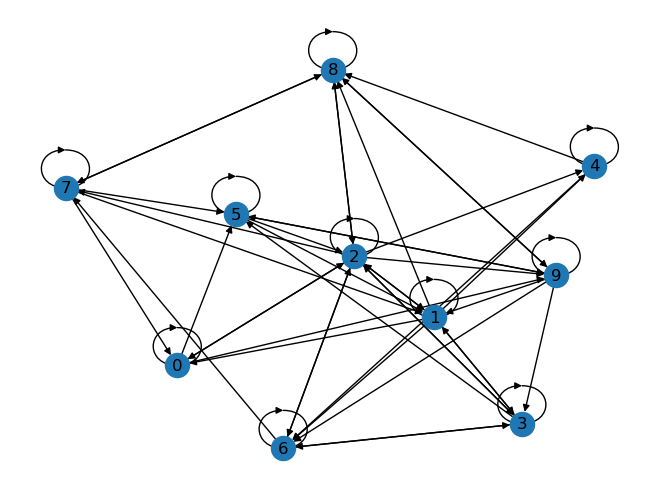

In [30]:
A2 = torch.randint(0, 2, (10, 10))
G2 = build_graph(A2)
nx.draw(G2, with_labels = True)

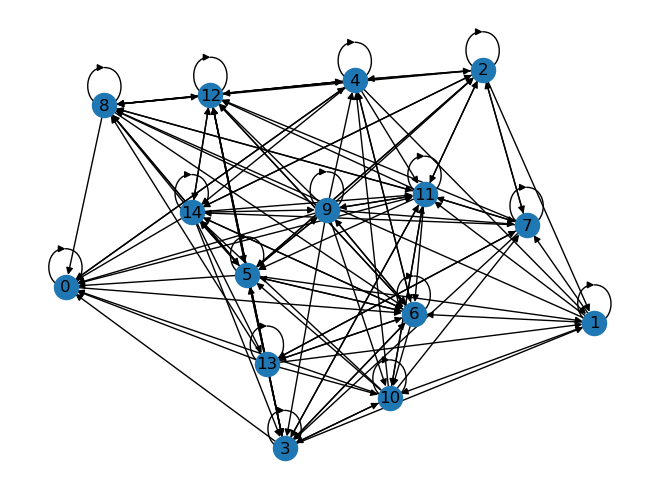

In [34]:
A3 = np.random.randint(2, size = (15, 15))
G3 = build_graph(A3)
nx.draw(G3, with_labels = True)

In [37]:
import networkx as nx 
from joblib import Parallel, delayed 
import random 
import itertools 
import numpy as np 
from gensim.models import Word2Vec 

In [38]:
def partition_num(num, workers):
    if num % workers == 0:
        return [num // workers] * workers
    else :
        return [num // workers] * workers + [num % workers]

In [48]:
class RandomWalker:
    def __init__(self, G, num_walks, walk_length):

        self.G = G
        self.num_walks = num_walks
        self.walk_length = walk_length

    def deepwalk_walk(self, start_node):

        walk = [start_node]
        current = start_node

        for _ in range(self.walk_length - 1):
            neighbors = list(self.G.neighbors(current))
            if len(neighbors) == 0: break

            next_node = random.choice(neighbors)
            walk.append(next_node)
            current = next_node

        return walk

    def walk_independent(self, nodes):
        walks = []

        for _ in range(self.num_walks):
            random.shuffle(nodes)

            for v in nodes:
                walk = self.deepwalk_walk(start_node = v)
                walks.append(walk)

        return walks

    def simulate_walks(self, workers = 1, verbose = 0):

        G = self.G
        nodes = list(G.nodes())

        results = Parallel(n_jobs = workers, verbose = verbose)(
          delayed(self.walk_independent)(nodes) 
          for num in partition_num(self.num_walks, workers)
        )

        walks = list(itertools.chain(*results))
        return walks

In [51]:
class DeepWalk:
    def __init__(self, graph, walk_length, num_walks, workers=1):

        self.graph = graph
        self.w2v_model = None
        self._embeddings = {}

        self.walker = RandomWalker(graph, num_walks = num_walks, walk_length = walk_length)
        self.sentences = self.walker.simulate_walks(workers = workers, verbose = 1)

    def train(self, embed_size = 128, window_size = 5, workers = 1, iter = 5, **kwargs):

        kwargs["sentences"] = self.sentences
        kwargs["min_count"] = kwargs.get("min_count", 0)
        kwargs["vector_size"] = embed_size
        kwargs["sg"] = 1  
        kwargs["hs"] = 1
        kwargs["workers"] = workers
        kwargs["window"] = window_size
        kwargs["epochs"] = iter

        print("Learning embedding vectors...")
        model = Word2Vec(**kwargs)
        print("Learning embedding vectors done!")

        self.w2v_model = model
        return model

    def get_embeddings(self,):
        if self.w2v_model is None:
            print("model not train")
            return {}

        self._embeddings = {}
        for word in self.graph.nodes():
            self._embeddings[word] = self.w2v_model.wv[word]

        return self._embeddings

In [54]:
G = nx.read_edgelist('lab1/lab1_big_edgelist.txt', create_using = nx.DiGraph(),
                     nodetype = None, data = [('weight', int)])
model = DeepWalk(G, walk_length = 10, num_walks = 80, workers = 1)
model.train(window_size = 5, iter = 3)
embeddings = model.get_embeddings()

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished


Learning embedding vectors...
Learning embedding vectors done!


In [55]:
count = 0
for i, (k, v) in enumerate(embeddings.items()):
  print("Index {} has key {} and value {}".format(str(i), k, v))
  count += 1
  if count == 2:
    break

Index 0 has key 1397 and value [ 2.14621723e-02 -4.61869150e-01 -6.02679372e-01  1.73694730e-01
  6.71559989e-01  3.43910545e-01  8.04048106e-02 -2.58262064e-02
  7.79599771e-02 -5.04144192e-01 -8.73803258e-01 -1.62284911e-01
 -2.28431582e-01  8.53626505e-02 -1.00297369e-01 -6.06240556e-02
 -9.20220315e-02  4.09165919e-01 -1.15789510e-02 -3.19889300e-02
  4.59395409e-01 -1.61880106e-01 -2.67315328e-01 -4.31537718e-01
 -1.24306776e-01 -2.93612778e-01  8.52333754e-02 -1.64496690e-01
 -2.06821471e-01  6.34901747e-02 -1.76791370e-01 -4.90507066e-01
  8.66483971e-02  1.25920907e-01  4.53345239e-01 -3.98147702e-02
  9.35590938e-02  8.31896216e-02 -1.98769212e-01  2.45002322e-02
  3.14352632e-01  7.02866074e-03 -3.91976237e-01 -8.66559371e-02
 -5.04668057e-01  6.27842173e-02 -3.53454977e-01  8.13659281e-02
 -3.32067579e-01  3.80218208e-01  6.25557899e-01 -3.36141326e-02
  1.99790254e-01  4.43475634e-01  2.66007185e-01  2.18718603e-01
  7.49254599e-02  1.94959164e-01  1.98150918e-01  3.2406166